In [8]:
import pickle as cp
import numpy as np
import matplotlib.pyplot as plt

X, y = cp.load(open('winequality-white.pickle', 'rb'))


N, D = X.shape
# use 80-20 split for train and test data
N_train = int(0.8 * N)
N_test = N - N_train
X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:]
y_test = y[N_train:]

(array([  20.,  163.,    0., 1457.,    0., 2198.,  880.,    0.,  175.,
           5.]),
 array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]),
 <BarContainer object of 10 artists>)

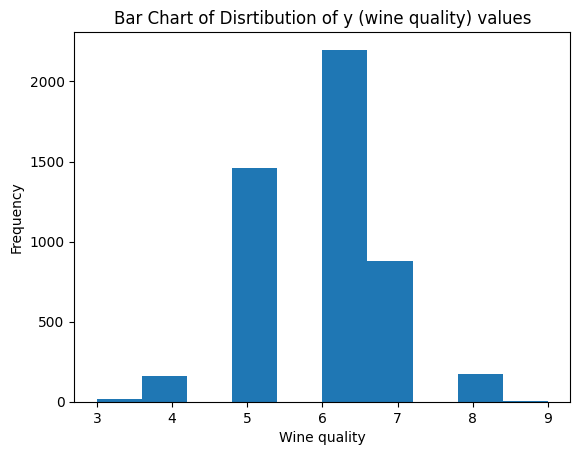

In [9]:
# Handin 1
plt.title("Bar Chart of Disrtibution of y (wine quality) values")
plt.xlabel("Wine quality")
plt.ylabel("Frequency")
plt.hist(y)

In [10]:
# Handin 2
y_hat = np.mean(y_train)
mse_train = np.linalg.norm(y_train-y_hat)**2 / N_train
mse_test = np.linalg.norm(y_test-y_hat)**2 / N_test
print(f"Train mean squared error: {mse_train}") 
print(f"Test mean squared error: {mse_test}") 

Train mean squared error: 0.7767772386501046
Test mean squared error: 0.8138573000045533


In [11]:
# Handin 3

# Firstly, standardisation is not strictly necessary as there is no regularisation. So, the distribution of values of the 
# features won't affect model (ignoring numerical precision, etc.).

means = X_train.mean(0)
stds = X_train.std(0)
X_train_std = (X_train - means) / stds
X_test_std = (X_test - means) / stds

ones_train = np.ones((N_train,1))
X_train_std_bias = np.hstack((X_train_std,ones_train))
ones_test= np.ones((N_test,1))
X_test_std_bias = np.hstack((X_test_std,ones_test))

# Linear model w = ((X^T)X)^(-1)(X^T)y
def train(X,y):
    X_T = X.transpose()
    inverse = np.linalg.inv(np.matmul(X_T,X))
    matrix = np.matmul(inverse,X_T)
    w = np.matmul(matrix,y)
    return w
# mse = length(Xw-y)**2 / N
def mse(X,w,y,N):
    return np.linalg.norm(np.matmul(X,w)-y)**2 / N

w = train(X_train_std_bias, y_train)


mse_linear_train = mse(X_train_std_bias,w, y_train, N_train)
mse_linear_test = mse(X_test_std_bias,w, y_test, N_test)
print(f"Train mean squared error: {mse_linear_train}")
print(f"Test mean squared error: {mse_linear_test}")

Train mean squared error: 0.5639996173941926
Test mean squared error: 0.560729204228347


480 0.5609190172422288


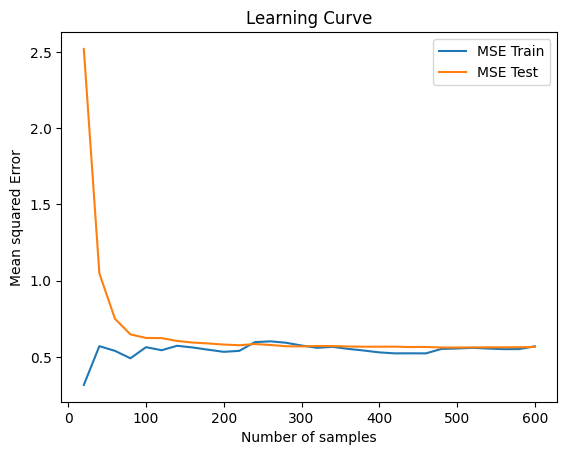

In [12]:
# Handin 4
sizes = range(20,601,20)
mse_trains = []
mse_tests = []

for size in sizes:
    X_t = X_train_std_bias[:size]
    y_t = y_train[:size]
    w = train(X_t,y_t)
    mse_train = mse(X_t,w,y_t,size)
    mse_test = mse(X_test_std_bias,w,y_test,N_test) 
    mse_trains.append(mse_train)
    mse_tests.append(mse_test)

plt.title("Learning Curve")
plt.xlabel("Number of samples")
plt.ylabel("Mean squared Error")
plt.plot(sizes, mse_trains, label = "MSE Train")
plt.plot(sizes, mse_tests, label = "MSE Test")
plt.legend()

print(sizes[np.argmin(mse_tests)], min(mse_tests))
# I think the model is underfitting as the train and test error are about the same after 200 samples. 
# So more data is not improving the model prediction, showing underfitting of data.
# The best test error of 0.5609190172422288 is achieved after 480 samples.

In [13]:
from sklearn import linear_model, preprocessing, pipeline
import numpy as np

degree = 2

# Split data for hyperparameter tuning and validation
N_hyper = int(N_train * 0.8)
X_hyper, y_hyper = X_train[:N_hyper], y_train[:N_hyper]
X_validate, y_validate = X_train[N_hyper:], y_train[N_hyper:]

# Define hyperparameters and scoring function
lambdas = [10**i for i in range(-2, 3)]

def calculate_score(y_pred, y_true, N):
    return np.linalg.norm(y_pred - y_true)**2 / N

# Helper function to evaluate models with different lambdas
def evaluate_model(ModelClass, X_hyper, y_hyper, X_validate, y_validate, lambdas):
    scores = []
    for l in lambdas:
        model = pipeline.make_pipeline(
            preprocessing.StandardScaler(),
            preprocessing.PolynomialFeatures(degree),
            ModelClass(alpha=l)
        )
        model.fit(X_hyper, y_hyper)
        y_pred = model.predict(X_validate)
        scores.append(calculate_score(y_pred, y_validate, len(y_validate)))
    best_lambda = lambdas[np.argmin(scores)]
    return best_lambda, min(scores), scores

# Ridge regression evaluation
rbest, min_ridge_score, ridge_scores = evaluate_model(linear_model.Ridge, X_hyper, y_hyper, X_validate, y_validate, lambdas)
print("Ridge Scores:", ridge_scores)
print(f"Best Ridge Lambda: {rbest}, Score: {min_ridge_score}")

# Train final Ridge model
ridge_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    preprocessing.PolynomialFeatures(degree),
    linear_model.Ridge(alpha=rbest)
)
ridge_model.fit(X_train, y_train)
print(f"Ridge Train Error: {calculate_score(ridge_model.predict(X_train), y_train, N_train)}")
print(f"Ridge Test Error: {calculate_score(ridge_model.predict(X_test), y_test, N_test)}")

# Lasso regression evaluation
lbest, min_lasso_score, lasso_scores = evaluate_model(linear_model.Lasso, X_hyper, y_hyper, X_validate, y_validate, lambdas)
print("Lasso Scores:", lasso_scores)
print(f"Best Lasso Lambda: {lbest}, Score: {min_lasso_score}")

# Train final Lasso model
lasso_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    preprocessing.PolynomialFeatures(degree),
    linear_model.Lasso(alpha=lbest)
)
lasso_model.fit(X_train, y_train)
print(f"Lasso Train Error: {calculate_score(lasso_model.predict(X_train), y_train, N_train)}")
print(f"Lasso Test Error: {calculate_score(lasso_model.predict(X_test), y_test, N_test)}")

Ridge Scores: [0.5290409085654489, 0.5289551285436442, 0.5283390496604266, 0.5278339996699376, 0.5354982118924382]
Best Ridge Lambda: 10, Score: 0.5278339996699376
Ridge Train Error: 0.49546310413856376
Ridge Test Error: 0.5116677456584304
Lasso Scores: [0.5462937892321523, 0.6232071472689208, 0.7906338833411325, 0.7906338833411325, 0.7906338833411325]
Best Lasso Lambda: 0.01, Score: 0.5462937892321523
Lasso Train Error: 0.5138328252782883
Lasso Test Error: 0.5185523039167392


In [14]:
for d in range(1,6):
    ridge_model = pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        preprocessing.PolynomialFeatures(d),
        linear_model.RidgeCV(alphas=lambdas)
    )
    ridge_model.fit(X_train,y_train)
    print(d, ":", calculate_score(ridge_model.predict(X_test), y_test, N_test))

1 : 0.5627429032097289
2 : 0.5116677456584026
3 : 0.6742163314934768
4 : 2.0845051778180848
5 : 45.88361913238902
